In [113]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim




In [114]:
torch.cuda.device_count()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [115]:
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')


In [116]:
trainset = torchvision.datasets.MNIST(root='./data', train=True, 
                                      download=True, 
                                      transform=transforms.ToTensor())

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())


trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)


In [117]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

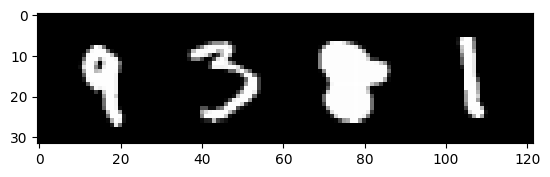

9 3 8 1


In [118]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print(' '.join(str(classes[labels[j].item()]) for j in range(4)))

In [119]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the input
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [120]:
net = SimpleNet().to(device)
loss_fn = nn.CrossEntropyLoss()

optimizer = optim.Adam(net.parameters(), lr=0.001)


In [121]:
def evaluation(dataloader):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [122]:
loss_arr = []
loss_epoch_arr = []
max_epochs = 10

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        loss_arr.append(loss.item())
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (epoch + 1, max_epochs, evaluation(testloader), evaluation(trainloader)))

# Plot the loss
plt.plot(loss_epoch_arr)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


KeyboardInterrupt: 

In [124]:
def entropy(p):
    return -torch.sum(p * torch.log2(p + 1e-8), dim=1)

In [125]:
def evaluate_model(model, dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [126]:
# Active learning loop
max_iterations = 5
num_labeled_samples = 1000
acquisition_batch_size = 50 # highest uncertainty point in each iteration.

In [127]:
labeled_indices = np.random.choice(len(trainset), num_labeled_samples, replace=False)
unlabeled_indices = list(set(range(len(trainset))) - set(labeled_indices))
labeled_dataset = torch.utils.data.Subset(trainset, labeled_indices)
unlabeled_dataset = torch.utils.data.Subset(trainset, unlabeled_indices)

In [130]:
    model = SimpleNet()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.CrossEntropyLoss()

In [131]:
# Active learning iterations
for iteration in range(max_iterations):
    print(f"\nActive Learning Iteration {iteration + 1}/{max_iterations}")

    # Calculate model predictions and entropy for the unlabeled dataset
    predictions = []
    with torch.no_grad():
        for data in unlabeled_dataset:
            inputs, _ = data
            outputs = model(inputs.unsqueeze(0))
            predictions.append(outputs.softmax(dim=1))

    entropies = entropy(torch.cat(predictions))

    # Select the top samples with highest entropy for labeling
    top_indices = np.argsort(entropies)[-acquisition_batch_size:]
    labeled_indices = np.concatenate((labeled_indices, np.array(unlabeled_indices)[top_indices]))
    unlabeled_indices = list(set(unlabeled_indices) - set(np.array(unlabeled_indices)[top_indices]))

    # Update labeled and unlabeled datasets
    labeled_dataset = torch.utils.data.Subset(trainset, labeled_indices)
    unlabeled_dataset = torch.utils.data.Subset(trainset, unlabeled_indices)

    # Train the model on the updated labeled dataset
    for epoch in range(5):  # Adjust the number of epochs as needed
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
    test_accuracy = evaluate_model(model, testloader)
    print(f"Test Accuracy: {test_accuracy:.2f}%")




Active Learning Iteration 1/5


In [ ]:
final_test_accuracy = evaluate_model(model, testloader)
print(f"\nFinal Test Accuracy: {final_test_accuracy:.2f}%")